# COVID-19 Voice Detection
[Data Information]   
Data Source: https://dacon.io/competitions/official/235910/overview/description   
Raw Data Type : wav, csv

[Voice Data]   
train_wav : 3805개   
test_wav : 5732개   
unlabeled_wav : 1867개   

[Voice Data Format]   
CFG = {   
    'SR' : 16000,     # 주파수(Sample_rate)   
    'N_MFCC' : 15,    # MFCC 벡터를 추출할 개수   
    'SEED' : 41,      # 시드(Random Seed)   
    'N_MELS' : 128    # 고주파 대역 스케일(Mel Scale)   
}   

[Csv Data]   
train_csv : (3805,6)   
test_csv : (5732,5)   
unlabeled_csv : (1867,5)   

[Version]   
1st Advanced MFCC Feature, f1_score, GNB -> MLP, Semi-Supervised Learning

## 0. Setting

### Path Check

In [1]:
pwd

'C:\\myPyCode\\Code lion\\COVID-19 Voice Detection'

In [2]:
ls

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: A494-C8A8

 C:\myPyCode\Code lion\COVID-19 Voice Detection 디렉터리

2022-08-23  오후 05:46    <DIR>          .
2022-08-23  오후 05:46    <DIR>          ..
2022-08-23  오후 05:02    <DIR>          .ipynb_checkpoints
2022-08-23  오후 05:46         1,043,358 COVID-19 Voice Detection MLP Semi Supervised Main.ipynb
2022-08-23  오후 04:04    <DIR>          data
2022-08-23  오후 01:53    <DIR>          docs
2022-08-23  오후 04:35    <DIR>          low version
2022-08-23  오후 04:05    <DIR>          model_save
               1개 파일           1,043,358 바이트
               7개 디렉터리  14,035,189,760 바이트 남음


### Library Call

In [52]:
# pip install librosa

In [55]:
# pip install xgboost

In [56]:
# pip install lightgbm

In [1]:
# 상용 라이브러리
from glob import glob
import os
import pandas as pd
import numpy as np
import datetime as dt
import time
from tqdm import tqdm
import librosa
import random
import IPython
import pickle

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

# 한글 폰트 패치
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   

# 시각화 포맷 설정
plt.style.use("ggplot")
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# sckit-learn
# sckit-learn preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

# ML Model Library
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC ,LinearSVC
from sklearn.ensemble import  RandomForestClassifier ,AdaBoostClassifier ,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
# from xgboost import XGBoostClassifier, plot_importance
from lightgbm import LGBMClassifier, plot_importance

# Clf Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, precision_recall_curve

### User Function Definition

In [2]:
# ------------- WAV File Load & Preprocessing ------------- #
# Global Constant Definition
root_dir = 'C:\\myPyCode\\Code lion\\COVID-19 Voice Detection'
CFG = {
    'SR' : 16000,     # 주파수(Sample_rate)
    'N_MFCC' : 15,    # MFCC 벡터를 추출할 개수
    'SEED' : 41,      # 시드(Random Seed)
    'N_MELS' : 128    # 고주파 대역 스케일(Mel Scale)
}

# Fixing Every Random Seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

# MFCC(Mel-Frequency Cepstral Coefficient) : 음성데이터를 다루기 쉬운 형태로 피처화
def get_mfcc_feature(df, data_type, save_path):
    # Data Folder path
    root_folder = './data'
    if os.path.exists(save_path):
        print(f'{save_path} is exist.')
        return
    features = []
    for uid in tqdm(df['id']):
        root_path = os.path.join(root_folder, data_type)
        path = os.path.join(root_path, str(uid).zfill(5)+'.wav')

        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)
    
    # 기존의 자가진단 정보를 담은 데이터프레임에 추출된 오디오 Feature를 추가
    mfcc_df = pd.DataFrame(features, columns=['mfcc_'+str(x) for x in range(1,CFG['N_MFCC']+1)])
    df = pd.concat([df, mfcc_df], axis=1)
    df.to_csv(save_path, index=False)
    print('Done.')

# One-Hot Encoding
def onehot_encoding(ohe, x):
    # 학습데이터로 부터 fit된 one-hot encoder (ohe)를 받아 transform 시켜주는 함수
    encoded = ohe.transform(x['gender'].values.reshape(-1,1))
    encoded_df = pd.DataFrame(encoded, columns=ohe.categories_[0])
    x = pd.concat([x.drop(columns=['gender']), encoded_df], axis=1)
    return x

# ------------- WAV File Visualization ------------- #
# WAV Plot
def wav_plot(y, sr):
    time = np.linspace(0, len(y)/sr, len(y))
    fig, ax = plt.subplots()
    ax.plot(time, y, color = 'g')
    ax.set_xlabel('Time')
    ax.set_ylabel('Voice')
    plt.title('WAV Plot')
    plt.show()

# WAV Display
def wav_display(y, sr):
    return IPython.display.Audio(data = y, rate = sr)

# ------------- ML Modeling ------------- #
# ML GridSearchCV
def ML_search(X_train,y_train,X_test,y_test):
    lr = LogisticRegression(random_state=42)
    svm = SVC(random_state=42)
    rf  = RandomForestClassifier(random_state=42)
    dt = DecisionTreeClassifier(random_state=42)
    gus = GaussianNB()
    knn = KNeighborsClassifier()
    lin_svc = LinearSVC(random_state=42)
    ada = AdaBoostClassifier(random_state=42)
    grd  = GradientBoostingClassifier(random_state=42)
    lgbm = LGBMClassifier(random_state=42)
    mlp = MLPClassifier(random_state=42)
    
    models = [lr, svm, rf, dt, gus, knn, lin_svc, ada, grd, lgbm, mlp]
    models_result = []
    
    for model in models:
        model.fit(X_train,y_train)
        pred = model.predict(X_test)
        pre = precision_score(y_test,pred)
        rec = recall_score(y_test,pred)
        f1 = f1_score(y_test,pred)
        acc = accuracy_score(y_test,pred)
        models_result.append([model,acc,f1,pre,rec])
        
    df = pd.DataFrame(models_result, columns=['name','acc','f1','precision','recall'])
    return df

# Get MLPClassifier Format
def get_mlp_format(model):
    print('n_features :',model.n_features_in_)
    print('n_iter :',model.n_iter_)
    print('n_layers :',model.n_layers_)
    print('n_outputs :',model.n_outputs_)
    print('out_activation :',model.out_activation_)
    return None

# MLP Post Tuning
def mlp_post_tuning(y_pred_proba_1,lower,upper):
    post_result = pd.DataFrame(columns=['acc','pre','rec','f1'])
    proba_grid = np.arange(lower,upper,0.01)
    for proba in proba_grid:
        ele =  np.where(y_pred_proba_1 < proba, 0, 1)
        ele_result = get_clf_eval(y_valid, ele)
        post_result = pd.concat([post_result,pd.DataFrame(ele_result,index=['acc','pre','rec','f1']).T],axis=0)
    post_result.index = proba_grid
    post_result.reset_index(inplace=True)
    post_result.rename(columns={'index':'proba'},inplace=True)
    return post_result

# ------------- Performance Evaluation Metrics ------------- #
# Get Clf Evaluation Metrics
def get_clf_eval(y_test,pred):
    cf = confusion_matrix(y_test,pred)
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred)
    rec = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    
    print(cf)
    print('정확도 :{0:.4f}, 정밀도 :{1:.4f}, 재현율 :{2:.4f}, F1 :{3:.4f}'.format(acc,pre,rec,f1))
    return [acc, pre, rec, f1]        
        
# 정확도 재현율 곡선
def precision_recall_curve_plot(y_test,pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    plt.axvline(x=0.5, label='Normal Threshold', linestyle=':', alpha=0.8, color='green')
    
    start,end = plt.xlim()
    plt.title('Precision Recall Curve', size=20)
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# ROC 곡선 
def roc_curve_plot(y_test, pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba)
    
    plt.figure(figsize=(8,6))
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1],[0,1],linestyle='--', label='Random', color='k')
    start, end = plt.xlim()
    plt.title('Roc Auc Curve', size=20)
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1 - Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()

## 1. Data Load

In [3]:
# CSV data load
train_csv = pd.read_csv('data/train_data.csv')
test_csv = pd.read_csv('data/test_data.csv')
unlabeled_csv = pd.read_csv('data/unlabeled_data.csv')

print(train_csv.shape, test_csv.shape, unlabeled_csv.shape)
train_csv.head()

(3805, 6) (5732, 5) (1867, 5)


,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19
0,1,24,female,0,1,0
1,2,51,male,0,0,0
2,3,22,male,0,0,0
3,4,29,female,1,0,0
4,5,23,male,0,0,0


In [6]:
test_csv.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain
0,3806,48,female,1,0
1,3807,24,female,0,0
2,3808,29,male,0,0
3,3809,39,female,0,0
4,3810,34,male,0,0


In [7]:
unlabeled_csv.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain
0,9538,35,male,1,0
1,9539,40,female,0,1
2,9540,33,male,0,0
3,9541,35,male,0,0
4,9542,54,female,0,0


In [7]:
# # MFCC(Mel-Frequency Cepstral Coefficient) Feature 
# get_mfcc_feature(train_csv.copy(), 'train', 'MFCC/train_mfcc_data_added.csv')
# get_mfcc_feature(test_csv.copy(), 'test', 'MFCC/test_mfcc_data_added.csv')
# get_mfcc_feature(unlabeled_csv.copy(), 'unlabeled', 'MFCC/unlabeled_mfcc_data_added.csv')

In [4]:
# Train & Test Data Load

# wav 파일의 MFCC Feature와 상태정보를 합친 학습데이터를 불러옵니다.
train_df = pd.read_csv('data/MFCC/train_mfcc_data.csv')
test_df = pd.read_csv('data/MFCC/test_mfcc_data.csv')
unlabeled_df = pd.read_csv('data/MFCC/unlabeled_mfcc_data.csv')

print(train_df.shape, test_df.shape, unlabeled_df.shape)
train_df.head()

(3805, 38) (5732, 37) (1867, 37)


,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,mfcc_23,mfcc_24,mfcc_25,mfcc_26,mfcc_27,mfcc_28,mfcc_29,mfcc_30,mfcc_31,mfcc_32
0,1,24,female,0,1,0,-276.01898,30.519340,-20.314617,-6.689037,...,-2.679408,2.454339,-1.176285,2.314315,-0.339533,2.514413,-4.784703,1.239072,-1.556883,-1.548770
1,2,51,male,0,0,0,-312.99362,54.141323,-1.748550,-9.437217,...,-7.248304,1.238725,-6.894970,-1.810402,-7.259594,0.715029,-1.372265,-1.760624,-2.735181,1.134190
2,3,22,male,0,0,0,-438.60306,46.675842,-22.771935,-3.527922,...,-0.136723,-1.707353,2.649277,1.208829,-0.033701,-1.008729,-0.687255,-0.472232,0.850565,0.353839
3,4,29,female,1,0,0,-369.26100,47.762012,-8.256503,-2.891349,...,-0.389230,4.033148,-2.658165,2.867084,1.679876,2.136411,0.289792,1.709179,-0.592465,1.754549
4,5,23,male,0,0,0,-535.68915,7.509357,-7.762263,2.567660,...,-0.279360,-0.292286,-1.559678,0.328864,-1.053423,0.844060,-0.788914,1.182740,-0.527028,1.208361


In [9]:
# Single Sample
sample_idx = np.random.choice(np.arange(1,train_df.shape[0]),1)[0]
sample_path = 'data/train/' + str(sample_idx).zfill(5) + '.wav'
print(sample_path)
y,sr = librosa.load(sample_path, sr = CFG['SR'])

data/train/01985.wav


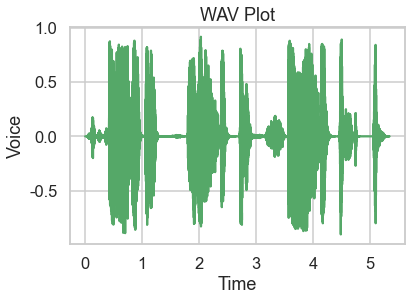

In [10]:
# WAV Sample Visualization
wav_plot(y, sr)

In [11]:
# WAV Sample Display
wav_display(y, sr)

0    3499
1     306
Name: covid19, dtype: int64


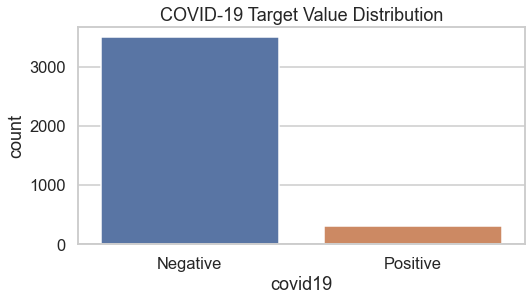

In [12]:
# Target value Distribution
print(train_df['covid19'].value_counts())

plt.figure(figsize=(8,4))
plt.title('COVID-19 Target Value Distribution')
sns.countplot(train_df['covid19'])
plt.xticks([0,1],['Negative', 'Positive'])
plt.show()

## 2. Data Preprocessing

In [5]:
# Data Split
train_x = train_df.drop(columns=['id', 'covid19'])
train_y = train_df['covid19']
test_x = test_df.drop(columns=['id'])
unlabeled_x = unlabeled_df.drop(columns=['id'])

train_x.shape, train_y.shape, test_x.shape, unlabeled_x.shape

((3805, 36), (3805,), (5732, 36), (1867, 36))

In [6]:
# OneHotEncoding
ohe = OneHotEncoder(sparse=False)
ohe.fit(train_x['gender'].values.reshape(-1,1))
train_x = onehot_encoding(ohe, train_x)
test_x = onehot_encoding(ohe, test_x)
unlabeled_x = onehot_encoding(ohe, unlabeled_x)

train_x.shape, test_x.shape, unlabeled_x.shape

((3805, 38), (5732, 38), (1867, 38))

In [7]:
# # StandardScaler
# scaler = StandardScaler()
# train_scaled = scaler.fit_transform(train_x)
# test_scaled = scaler.transform(test_x)
# unlabeled_scaled = scaler.transform(unlabeled_x)

In [8]:
# Train Valid Data Split
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, stratify=train_y, random_state=42)

print('X_train.shape :',X_train.shape)
print('y_train.shape :',y_train.shape)
print('X_test.shape :',X_valid.shape)
print('y_test.shape :',y_valid.shape)

X_train.shape : (3044, 38)
y_train.shape : (3044,)
X_test.shape : (761, 38)
y_test.shape : (761,)


## 3. ML Model Search

### ML Model Selection

In [11]:
# Best ML Model Search
model_search = ML_search(X_train, y_train, X_valid, y_valid)
model_search.sort_values(by='f1',ascending=False).reset_index(drop=True)

,name,acc,f1,precision,recall
0,GaussianNB(),0.885677,0.314961,0.303030,0.327869
1,"(DecisionTreeClassifier(max_depth=1, random_st...",0.918528,0.162162,0.461538,0.098361
2,DecisionTreeClassifier(random_state=42),0.859396,0.144000,0.140625,0.147541
3,([DecisionTreeRegressor(criterion='friedman_ms...,0.918528,0.114286,0.444444,0.065574
4,MLPClassifier(random_state=42),0.905388,0.100000,0.210526,0.065574
5,LGBMClassifier(random_state=42),0.919842,0.061538,0.500000,0.032787
6,LogisticRegression(random_state=42),0.919842,0.031746,0.500000,0.016393
7,"(DecisionTreeClassifier(max_features='auto', r...",0.919842,0.031746,0.500000,0.016393
8,SVC(random_state=42),0.919842,0.000000,0.000000,0.000000
9,KNeighborsClassifier(),0.918528,0.000000,0.000000,0.000000


### HyperParameter Tuning

In [293]:
# GaussianNB Model Training
gnb_clf = GaussianNB()

param_grid = {
    'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}

start_time = time.time()
grid_cv = GridSearchCV(gnb_clf, cv=3, refit=True, param_grid=param_grid, n_jobs=-1, scoring = 'f1')
grid_cv.fit(X_train, y_train)
end_time = time.time()

In [294]:
# Training Time Measurements
duration = end_time - start_time
result = dt.timedelta(seconds=duration)
print('Training Time :',str(result).split('.')[0])

Training Time : 0:00:00


In [295]:
# GridSearchCV Result
score_df = pd.DataFrame(grid_cv.cv_results_)
score_df[['params','mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head(3)

,params,mean_test_score,rank_test_score
5,{'var_smoothing': 1e-07},0.270246,1
7,{'var_smoothing': 1e-09},0.270051,2
8,{'var_smoothing': 1e-10},0.270051,2


In [296]:
# Best HyperParameter & Score
print('best HyperParameter :',grid_cv.best_params_)
print('best Grid_CV Score :',np.round(grid_cv.best_score_,4))

best HyperParameter : {'var_smoothing': 1e-07}
best Grid_CV Score : 0.2702


In [306]:
# Best Estimator
best_est = grid_cv.best_estimator_

In [338]:
# GaussianNB Model Attributes
print('best_est.sigma_.shape :',best_est.sigma_.shape)
print('best_est.var_.shape :',best_est.var_.shape)
print('best_est.theta_.shape :',best_est.theta_.shape)

best_est.sigma_.shape : (2, 38)
best_est.var_.shape : (2, 38)
best_est.theta_.shape : (2, 38)


## 4. Semi-Supervised Learning

In [307]:
# Pre Semi-Supervised Model : GaussianNB
semi_model = best_est

In [308]:
# Training
start_time = time.time()
semi_model.fit(X_train, y_train)
end_time = time.time()

In [309]:
# Training Time Measurements
duration = end_time - start_time
result = dt.timedelta(seconds=duration)
print('Training Time :',str(result).split('.')[0])

Training Time : 0:00:00


In [310]:
# Test Data Prediction Probability
y_pred_proba = semi_model.predict_proba(X_valid)
y_pred_proba_1 = y_pred_proba[:,1]

In [311]:
# Post Tuning
post_result = mlp_post_tuning(y_pred_proba_1,0.01,0.8)

[[417 283]
 [ 18  43]]
정확도 :0.6045, 정밀도 :0.1319, 재현율 :0.7049, F1 :0.2222
[[498 202]
 [ 22  39]]
정확도 :0.7057, 정밀도 :0.1618, 재현율 :0.6393, F1 :0.2583
[[528 172]
 [ 27  34]]
정확도 :0.7385, 정밀도 :0.1650, 재현율 :0.5574, F1 :0.2547
[[547 153]
 [ 29  32]]
정확도 :0.7608, 정밀도 :0.1730, 재현율 :0.5246, F1 :0.2602
[[564 136]
 [ 30  31]]
정확도 :0.7819, 정밀도 :0.1856, 재현율 :0.5082, F1 :0.2719
[[572 128]
 [ 31  30]]
정확도 :0.7911, 정밀도 :0.1899, 재현율 :0.4918, F1 :0.2740
[[576 124]
 [ 32  29]]
정확도 :0.7950, 정밀도 :0.1895, 재현율 :0.4754, F1 :0.2710
[[581 119]
 [ 32  29]]
정확도 :0.8016, 정밀도 :0.1959, 재현율 :0.4754, F1 :0.2775
[[587 113]
 [ 32  29]]
정확도 :0.8095, 정밀도 :0.2042, 재현율 :0.4754, F1 :0.2857
[[594 106]
 [ 32  29]]
정확도 :0.8187, 정밀도 :0.2148, 재현율 :0.4754, F1 :0.2959
[[600 100]
 [ 33  28]]
정확도 :0.8252, 정밀도 :0.2188, 재현율 :0.4590, F1 :0.2963
[[603  97]
 [ 34  27]]
정확도 :0.8279, 정밀도 :0.2177, 재현율 :0.4426, F1 :0.2919
[[604  96]
 [ 34  27]]
정확도 :0.8292, 정밀도 :0.2195, 재현율 :0.4426, F1 :0.2935
[[605  95]
 [ 34  27]]
정확도 :0.8305, 정밀도 :0.2213, 재현

In [312]:
# Post Tuning Result
post_result.sort_values(by='f1', ascending=False).head()

,proba,acc,pre,rec,f1
54,0.55,0.890933,0.322581,0.327869,0.325203
52,0.53,0.888305,0.3125,0.327869,0.32
53,0.54,0.888305,0.3125,0.327869,0.32
42,0.43,0.876478,0.285714,0.360656,0.318841
70,0.71,0.898817,0.346154,0.295082,0.318584


In [313]:
# Semi-Supervised Model
semi_pred_proba = semi_model.predict_proba(unlabeled_x)
semi_pred_proba_1 = semi_pred_proba[:,1]

In [314]:
# Semi-Supervised Model
semi_proba = 0.55
semi_prediction =  np.where(semi_pred_proba_1 < semi_proba, 0, 1)

In [315]:
# Unlabeled Data Labeling
unlabeled_x['covid19'] = -1
unlabeled_x['covid19'] = semi_prediction

0    1494
1     373
Name: covid19, dtype: int64


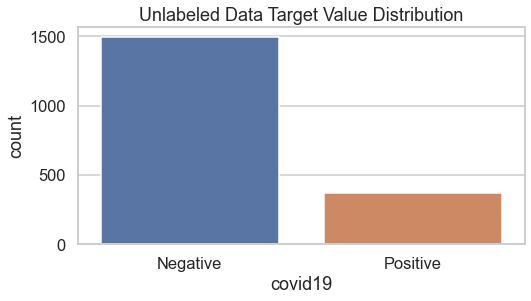

In [316]:
# Unlabeled Data value Distribution
print(unlabeled_x['covid19'].value_counts())

plt.figure(figsize=(8,4))
plt.title('Unlabeled Data Target Value Distribution')
sns.countplot(unlabeled_x['covid19'])
plt.xticks([0,1],['Negative', 'Positive'])
plt.show()

In [317]:
# Unlabeled Data Split
unlabeled_y = unlabeled_x['covid19']
unlabeled_x = unlabeled_x.drop(['covid19'], axis = 1)

unlabeled_x.shape, unlabeled_y.shape

((1867, 38), (1867,))

In [318]:
# Total DataSet Definition
all_x = pd.concat([train_x, unlabeled_x], axis=0)
all_y = pd.concat([train_y, unlabeled_y], axis=0)

all_x.shape, all_y.shape

((5672, 38), (5672,))

0    4993
1     679
Name: covid19, dtype: int64


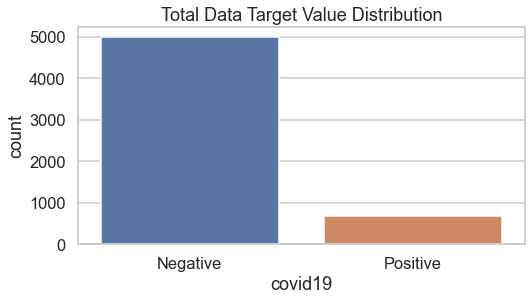

In [319]:
# Total Data value Distribution
print(all_y.value_counts())

plt.figure(figsize=(8,4))
plt.title('Total Data Target Value Distribution')
sns.countplot(all_y)
plt.xticks([0,1],['Negative', 'Positive'])
plt.show()

## 5. ML Modeling

In [339]:
# MLPClassifier
model = MLPClassifier(activation = 'relu', solver = 'adam', random_state=42)

In [340]:
# Training
start_time = time.time()
model.fit(all_x, all_y)
end_time = time.time()

In [341]:
# Training Time Measurements
duration = end_time - start_time
result = dt.timedelta(seconds=duration)
print('Training Time :',str(result).split('.')[0])

Training Time : 0:00:05


In [342]:
# Parameter coefficients 
print("Neural Network Parameter's format",model.coefs_[0].shape, model.coefs_[1].shape)

Neural Network Parameter's format (38, 100) (100, 1)


In [345]:
# Get MLPClassifier Format
get_mlp_format(model)

n_features : 38
n_iter : 156
n_layers : 3
n_outputs : 1
out_activation : logistic


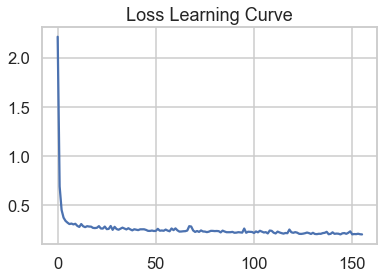

In [346]:
plt.title('Loss Learning Curve')
plt.plot(model.loss_curve_ )
plt.show()

## 6. Performance Evaluation

In [343]:
# Test Data Prediction
y_pred = model.predict(X_valid)
result = y_valid.to_frame().rename(columns={'covid19':'True'})
result['Pred'] = y_pred
print('result.shape :',result.shape)
result.head()

result.shape : (761, 2)


,True,Pred
3497,0,0
2167,0,0
2466,0,0
3744,0,0
223,0,0


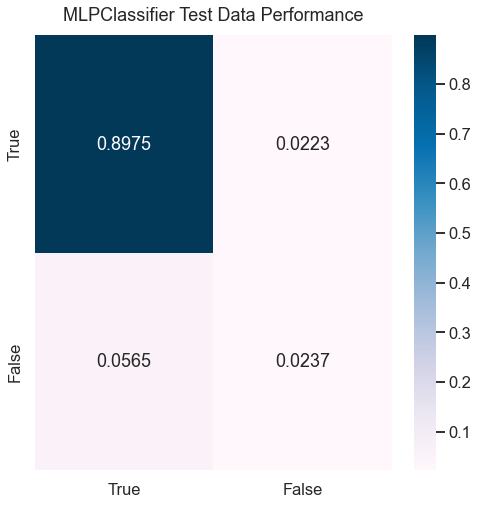

In [344]:
# Test Data Prediction Confusion Matrix
plt.figure(figsize=(8,8))
plt.title('MLPClassifier Test Data Performance',y=1.02)
sns.heatmap(confusion_matrix(result['True'],result['Pred'],normalize='all'), cmap='PuBu', annot=True, fmt='.4f')
plt.xticks([0.5,1.5],['True','False'])
plt.yticks([0.5,1.5],['True','False'])
plt.show()

In [325]:
# Get Clf Metrics
_ = get_clf_eval(result['True'],result['Pred'])

[[683  17]
 [ 43  18]]
정확도 :0.9212, 정밀도 :0.5143, 재현율 :0.2951, F1 :0.3750


In [326]:
# Test Data Prediction Probability
y_pred_proba = model.predict_proba(X_valid)
y_pred_proba_1 = y_pred_proba[:,1]

Roc Auc Score : 0.8761


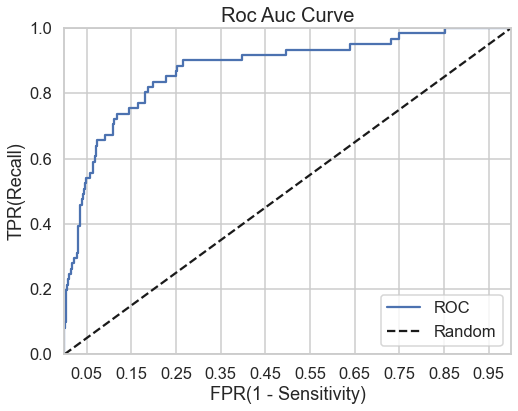

In [327]:
# ROC CURVE
print('Roc Auc Score :',np.round(roc_auc_score(y_valid,y_pred_proba_1),4))
roc_curve_plot(y_valid, y_pred_proba_1)

Precision : 0.5143
Recall : 0.2951


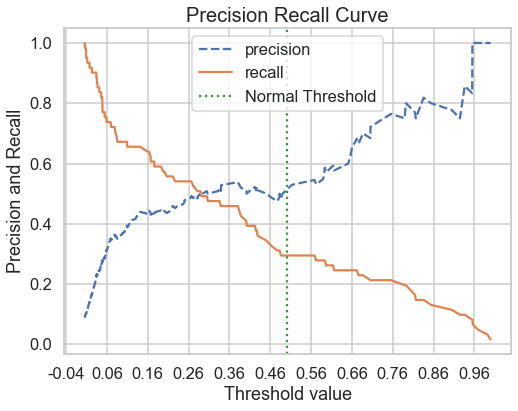

In [328]:
# Precision Recall Curve
print('Precision :',np.round(precision_score(y_valid,y_pred),4))
print('Recall :',np.round(recall_score(y_valid,y_pred),4))
precision_recall_curve_plot(y_valid,y_pred_proba_1)

## 7. Post Tuning

In [329]:
# Post Tuning
post_result = mlp_post_tuning(y_pred_proba_1,0.01,0.8)

[[216 484]
 [  3  58]]
정확도 :0.3601, 정밀도 :0.1070, 재현율 :0.9508, F1 :0.1924
[[390 310]
 [  5  56]]
정확도 :0.5861, 정밀도 :0.1530, 재현율 :0.9180, F1 :0.2623
[[479 221]
 [  6  55]]
정확도 :0.7017, 정밀도 :0.1993, 재현율 :0.9016, F1 :0.3264
[[538 162]
 [  9  52]]
정확도 :0.7753, 정밀도 :0.2430, 재현율 :0.8525, F1 :0.3782
[[577 123]
 [ 14  47]]
정확도 :0.8200, 정밀도 :0.2765, 재현율 :0.7705, F1 :0.4069
[[602  98]
 [ 16  45]]
정확도 :0.8502, 정밀도 :0.3147, 재현율 :0.7377, F1 :0.4412
[[617  83]
 [ 17  44]]
정확도 :0.8686, 정밀도 :0.3465, 재현율 :0.7213, F1 :0.4681
[[623  77]
 [ 18  43]]
정확도 :0.8752, 정밀도 :0.3583, 재현율 :0.7049, F1 :0.4751
[[628  72]
 [ 20  41]]
정확도 :0.8791, 정밀도 :0.3628, 재현율 :0.6721, F1 :0.4713
[[631  69]
 [ 20  41]]
정확도 :0.8830, 정밀도 :0.3727, 재현율 :0.6721, F1 :0.4795
[[638  62]
 [ 21  40]]
정확도 :0.8909, 정밀도 :0.3922, 재현율 :0.6557, F1 :0.4908
[[643  57]
 [ 21  40]]
정확도 :0.8975, 정밀도 :0.4124, 재현율 :0.6557, F1 :0.5063
[[644  56]
 [ 21  40]]
정확도 :0.8988, 정밀도 :0.4167, 재현율 :0.6557, F1 :0.5096
[[649  51]
 [ 21  40]]
정확도 :0.9054, 정밀도 :0.4396, 재현

In [330]:
# Post Tuning Result
post_result.sort_values(by='f1', ascending=False).head()

,proba,acc,pre,rec,f1
13,0.14,0.905388,0.43956,0.655738,0.526316
15,0.16,0.905388,0.438202,0.639344,0.52
14,0.15,0.904074,0.433333,0.639344,0.516556
25,0.26,0.917214,0.485294,0.540984,0.511628
12,0.13,0.898817,0.416667,0.655738,0.509554


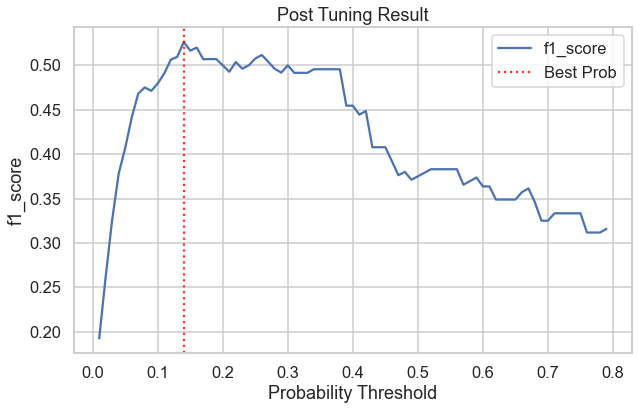

In [331]:
# Post Tuning Result Visualization
plt.figure(figsize=(10,6))
plt.plot(post_result['proba'], post_result['f1'], label='f1_score')
plt.title('Post Tuning Result')
plt.axvline(x=0.14, label='Best Prob', linestyle=':', alpha=0.8, color='red')
plt.xlabel('Probability Threshold')
plt.ylabel('f1_score')
plt.legend()
plt.show()

## 8. Test Submission 

In [332]:
# Sample Submission DataFrame
submit = pd.read_csv('data/sample_submission.csv')
print('submit :',submit.shape)
submit.head()

submit : (5732, 2)


,id,covid19
0,3806,-1
1,3807,-1
2,3808,-1
3,3809,-1
4,3810,-1


In [333]:
# Submission Data Prediction
y_sub_pred = model.predict_proba(test_x)[:,1]
sub_proba = 0.14
sub_prediction = np.where(y_sub_pred < sub_proba, 0, 1)

In [334]:
# Final Submission DataFrame
submit['covid19'] = sub_prediction
print('sub_result.shape :',submit.shape)
submit.head()

sub_result.shape : (5732, 2)


,id,covid19
0,3806,0
1,3807,0
2,3808,0
3,3809,0
4,3810,0


In [138]:
# # Submission Export
# file = 'data/submission/submit_0824.csv'
# submit.to_csv(file,index=False)

In [139]:
# # Submission Read
# pd.read_csv(file).head()

,id,covid19
0,3806,0
1,3807,0
2,3808,0
3,3809,0
4,3810,0


## 9. Simulation

### Model Save & Load

In [140]:
# Model path Definition
filename = 'model_save/mlp_second.sav'

In [141]:
# # MLP Model Save
# pickle.dump(model, open(filename, 'wb'))

In [142]:
# MLP Model Load
model = pickle.load(open(filename, 'rb'))

### Positive Sample Simulation

In [191]:
# Single Sample
# sample_idx = np.random.choice(np.arange(1,train_df.shape[0]),1)[0]
sample_idx = 185
sample_path = 'data/train/' + str(sample_idx).zfill(5) + '.wav'
print(sample_path)
y,sr = librosa.load(sample_path, sr = CFG['SR'])

data/train/00185.wav


In [192]:
# Object Profile
pd.DataFrame(train_x.iloc[sample_idx-1,:]).T[['age','respiratory_condition','fever_or_muscle_pain','female','male','other']]

,age,respiratory_condition,fever_or_muscle_pain,female,male,other
184,31.0,1.0,1.0,0.0,1.0,0.0


In [193]:
# WAV Sample Display
wav_display(y, sr)

In [194]:
# Sample WAV Prediction Result
sample_proba = 0.14
sample_data = np.array(train_x.iloc[sample_idx-1,:]).reshape(1,-1)
sample_pred = model.predict_proba(sample_data)[:,1][0]
sample_result = np.where(sample_pred < sample_proba, 0, 1)
sample_return = np.array(['Negative','Positive'])[sample_result]
print('sample_return :',sample_return)

sample_return : Positive


### Negative Sample Simulation

In [215]:
# Single Sample
# sample_idx = np.random.choice(np.arange(1,train_df.shape[0]),1)[0]
sample_idx = 107
sample_path = 'data/train/' + str(sample_idx).zfill(5) + '.wav'
print(sample_path)
y,sr = librosa.load(sample_path, sr = CFG['SR'])

data/train/00107.wav


In [216]:
# Object Profile
pd.DataFrame(train_x.iloc[sample_idx-1,:]).T[['age','respiratory_condition','fever_or_muscle_pain','female','male','other']]

,age,respiratory_condition,fever_or_muscle_pain,female,male,other
106,31.0,1.0,0.0,1.0,0.0,0.0


In [217]:
# WAV Sample Display
wav_display(y, sr)

In [218]:
# Sample WAV Prediction Result
sample_proba = 0.14
sample_data = np.array(train_x.iloc[sample_idx-1,:]).reshape(1,-1)
sample_pred = model.predict_proba(sample_data)[:,1][0]
sample_result = np.where(sample_pred < sample_proba, 0, 1)
sample_return = np.array(['Negative','Positive'])[sample_result]
print('sample_return :',sample_return)

sample_return : Negative
